# 04 - Overlap Management (Autoencoders)

*info for myself*
Overlap management with autoencoders is a technique to identify and handle noisy or overlapping data points in a dataset.

What is an Autoencoder?

An autoencoder is a type of neural network designed to learn a compressed (encoded) representation of the data.
It consists of two parts:
Encoder: Reduces the dimensionality of the data.
Decoder: Reconstructs the original data from the encoded representation.

In [12]:
# import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# Load the dataset
pd.set_option('display.float_format', '{:.1f}'.format)
df = pd.read_csv("Numeric data (last year work).csv")

In [14]:
# mormalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Define features and target
target_column = 'rating'  
X = scaled_data[:, :-1]  
y = scaled_data[:, -1]  

# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [15]:
# build the Autoencoder
input_dim = X_train.shape[1]  # Number of features
encoding_dim = int(input_dim / 2)  # Encoding dimension

# define the Autoencoder model
input_layer = tf.keras.layers.Input(shape=(input_dim,))
encoded = tf.keras.layers.Dense(encoding_dim, activation='relu')(input_layer)
decoded = tf.keras.layers.Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# train the Autoencoder
history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, X_test),
    verbose=1
)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2292 - val_loss: 0.2145
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2082 - val_loss: 0.1879
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1765 - val_loss: 0.1437
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1302 - val_loss: 0.1003
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0902 - val_loss: 0.0776
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0718 - val_loss: 0.0682
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0648 - val_loss: 0.0632
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0592 - val_loss: 0.0594
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0567 - val_loss: 0.0560
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0525 - val_loss: 0.0529
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0495 - val_loss: 0.0501
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0465 - val_lo

In [16]:
# reconstruction Errors
reconstructed_train = autoencoder.predict(X_train)
reconstructed_test = autoencoder.predict(X_test)

train_errors = np.mean((X_train - reconstructed_train) ** 2, axis=1)
test_errors = np.mean((X_test - reconstructed_test) ** 2, axis=1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [ ]:
# determine the threshold for anomalies
threshold = np.percentile(train_errors, 95) 
print(f"Reconstruction error threshold: {threshold}")

# Identify anomalies
anomalies_train = train_errors > threshold
anomalies_test = test_errors > threshold

print(f"Number of anomalies in training data: {np.sum(anomalies_train)}")
print(f"Number of anomalies in testing data: {np.sum(anomalies_test)}")

# insights:
# threshold: 0.030571836301641363 --> 95%
# This threshold helps ensure that only the top 5% 
# of the most deviant data points (outliers or overlaps) 
# are treated as anomalies. 

Reconstruction error threshold: 0.030571836301641363
Number of anomalies in training data: 40
Number of anomalies in testing data: 18


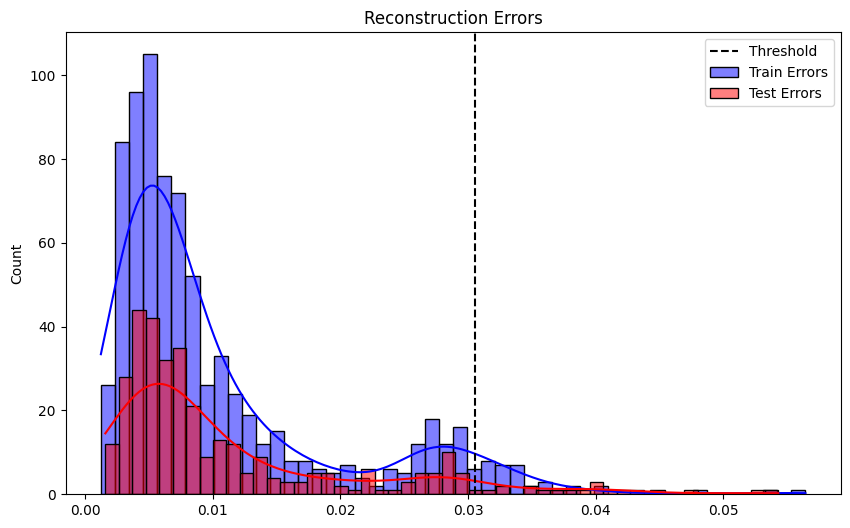

In [ ]:
# visualize reconstruction errors
plt.figure(figsize=(10, 6))
sns.histplot(train_errors, bins=50, kde=True, color='blue', label='Train Errors')
sns.histplot(test_errors, bins=50, kde=True, color='red', label='Test Errors')
plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
plt.title('Reconstruction Errors')
plt.legend()
plt.show()

# insights:
# The red and blue histograms overlap significantly 
# for errors below the threshold.
# this suggests that the patterns learned by the autoencoder 
# during training are applicable to the test data, 
# showing that the model is robust.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Filter inliers (cleaned data)
X_train_cleaned = X_train[~anomalies_train]
y_train_cleaned = y_train[~anomalies_train]

# Step 10: Train a Linear Regression Model on Cleaned Data
model = LinearRegression()
model.fit(X_train_cleaned, y_train_cleaned)

# Step 11: Evaluate the Model
predictions = model.predict(X_test)

# Denormalize predictions and test target for proper evaluation (if necessary)
y_test_original = scaler.inverse_transform(np.hstack([X_test, y_test.reshape(-1, 1)]))[:, -1]
predictions_original = scaler.inverse_transform(
    np.hstack([X_test, predictions.reshape(-1, 1)])
)[:, -1]

# Metrics
print("\nMetrics After Overlap Management:")
print("MAE:", round(mean_absolute_error(y_test_original, predictions_original), 2))
print("MSE:", round(mean_squared_error(y_test_original, predictions_original), 2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test_original, predictions_original)), 2))
print("R-squared:", round(r2_score(y_test_original, predictions_original), 2))

# insights:
# metrics are worse
# probably, autoencoder might have flagged 
# and removed too many data points as anomalies, 
# including some that were valid and informative 
# for training the linear regression model

# also, if the autoencoder misclassifies useful 
# data points as anomalies (e.g., edge cases or high-variance points), 
# the model loses critical information.

# moreover, after removing anomalies, the cleaned training 
# data might no longer reflect the distribution of the test set.

# furthermore, 
# If the autoencoder is not properly trained 
# (I had insufficient epochs or 
# inappropriate hyperparameters), 
# it might fail to accurately identify anomalies.


Metrics After Overlap Management:
MAE: 0.01
MSE: 0.0
RMSE: 0.04
R-squared: 0.47


C:\Users\e1003118\AppData\Local\Temp\ipykernel_3664\624181589.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test_original - predictions_original, kde=True)


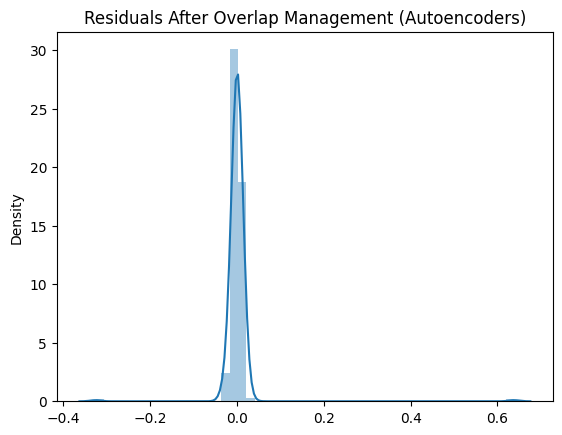

In [22]:
# Residuals Plot
sns.distplot(y_test_original - predictions_original, kde=True)
plt.title("Residuals After Overlap Management (Autoencoders)")
plt.show()

In [ ]:
# from my point of view,
# it is too sharp

# I think that it can indicate that the model 
# is underfitting and failing 
# to capture variability in the data.

screenshots

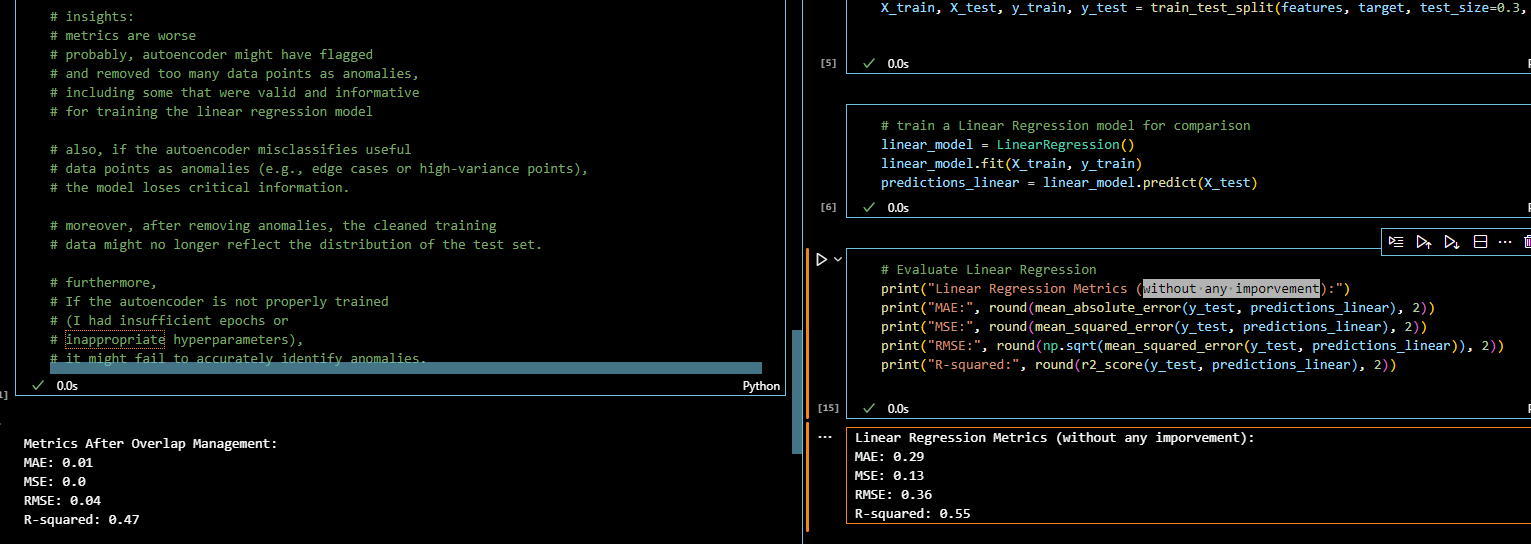

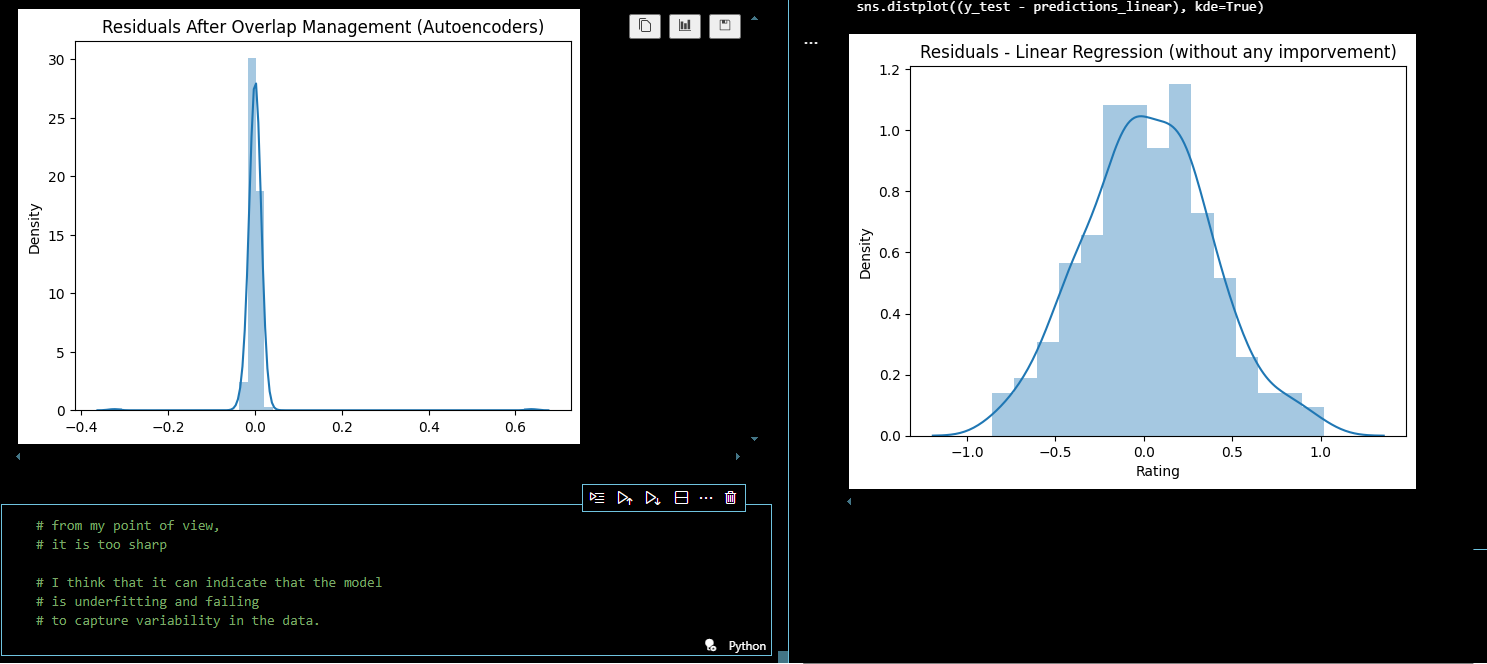